In [1]:
import sys
sys.path.append("../src")
from utils import get_experiment_name, save_cfg, set_seeds
from visualization import save_images
from renderer import Renderer

import functools
import cv2
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict

from score_sde.losses import get_optimizer
from score_sde.models.ema import ExponentialMovingAverage
from score_sde.utils import restore_checkpoint
from score_sde.models import utils as mutils
from score_sde.models import ncsnpp
from score_sde.sde_lib import VESDE
from score_sde.configs.ve import ffhq_256_ncsnpp_continuous as configs

cfg = {
    "seed": 0,
    "batch_size": 1,
    "image_size": 256,
    "texture_size": 2048, # Fix, 2048
    "saved_image_size": 256,
    "num_channels": 3,
    "image_save_dir": "../results",
    "device": torch.device("cuda:0"),
    "num_corrector_steps": 10,
    "sde_N": 1000, # Fix, 1000
    "snr": 0.01, # 0.015 large, 0.005 small
    "subject_id": 40044,
    "3dmm": "deca", # "tf_flame", "deca",
}
cfg["experiment_name"] = get_experiment_name()

if cfg["3dmm"] == "deca":
    cfg["texture_path"] = f"/local/home/aarslan/DECA/TestSamples/examples/results/{cfg['subject_id']}/{cfg['subject_id']}.png"
    cfg["obj_path"] = f"/local/home/aarslan/DECA/TestSamples/examples/results/{cfg['subject_id']}/{cfg['subject_id']}.obj"
elif cfg["3dmm"] == "tf_flame":
    cfg["texture_path"] = f"/local/home/aarslan/score-face/assets/FFHQ_results_2048_2020/{cfg['subject_id']}.png"
    cfg["obj_path"] = f"/local/home/aarslan/score-face/assets/FFHQ_results_2048_2020/{cfg['subject_id']}.obj"
else:
    raise Exception(f"Not a valid '3dmm' {cfg['3dmm']}")

set_seeds(cfg)
save_cfg(cfg)

ckpt_filename = "../assets/checkpoint_48.pth"
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=cfg["sde_N"])
sampling_eps = 1e-5

batch_size = cfg["batch_size"]
config.training.batch_size = batch_size
config.eval.batch_size = batch_size
config.device = cfg["device"]

sigmas = mutils.get_sigmas(config)
score_model = mutils.create_model(config)
score_model.eval()

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer, model=score_model, ema=ema)
state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

def render(texture, background, pixel_uvs, background_mask):
    texture_sampled = torch.nn.functional.grid_sample(torch.flip(texture, dims=[-2]), pixel_uvs, mode='nearest', padding_mode='border', align_corners=False)
    return torch.where(background_mask, background, texture_sampled)

image_shape = (cfg["batch_size"], cfg["num_channels"], cfg["image_size"], cfg["image_size"])
texture_shape = (cfg["batch_size"], cfg["num_channels"], cfg["texture_size"], cfg["texture_size"])

def get_score_fn(sde, score_model):
    def score_fn(x, vec_t):
        labels = sde.marginal_prob(torch.zeros_like(x), vec_t)[1]
        score = score_model(x, labels)
        return score
    return score_fn

probability_flow = False
score_fn = get_score_fn(sde, score_model)
rsde = sde.reverse(score_fn=score_fn, probability_flow=probability_flow)
timesteps = torch.linspace(sde.T, sampling_eps, sde.N)
zeros = torch.zeros(size=image_shape, device=cfg["device"])
background = torch.zeros(size=image_shape, device=cfg["device"])

flame_texture = cv2.imread(cfg["texture_path"])[:, :, [2, 1, 0]]
flame_texture = torch.tensor(flame_texture, device=cfg["device"]).unsqueeze(0) / 255.0 # (N, H, W, C)
flame_texture = flame_texture[0].cpu().numpy()
gray = cv2.cvtColor(flame_texture, cv2.COLOR_RGB2GRAY)
black_mask = gray <= 0
black_mask_moved = np.vstack((np.zeros((1, black_mask.shape[1])), black_mask[:-1, :]))
black_mask = np.logical_or(black_mask, black_mask_moved)
black_mask = np.tile(black_mask[:, :, None], reps=[1, 1, 3])
masked_texture = cv2.resize(np.clip(flame_texture + black_mask, 0, 1), dsize=(cfg["texture_size"], cfg["texture_size"]), interpolation=cv2.INTER_NEAREST)
masked_texture = torch.tensor(masked_texture, device=cfg["device"]).permute(2, 0, 1).unsqueeze(0)
filled_mask = (masked_texture.sum(axis=1, keepdim=True) != 3).repeat(repeats=[1, 3, 1, 1])

prerender_results = {}
elev = 0
azimuth = 0
renderer = Renderer(cfg=cfg)

background = torch.zeros(size=image_shape, device=cfg["device"])

v_us_mapping = {}
red_mask = cv2.imread("../assets/red_mask.png")[:, :, [2, 1, 0]]

for v in range(red_mask.shape[0]):
    v_us_mapping[v] = []
    for u in range(red_mask.shape[1]):
        if np.all(red_mask[v, u, :] == np.array([255, 38, 0])):
            v_us_mapping[v].append(u)


pixel_uvs, background_mask = renderer.render(texture=masked_texture, background=background, elev=elev, azimuth=azimuth, result_keys=["pixel_uvs", "background_mask"])
# prerender_results[f"{elev}_{azimuth}"] = {"pixel_uvs": pixel_uvs,
#                                           "background_mask": background_mask}

# pixel_uvs = prerender_results[f"{elev}_{azimuth}"]["pixel_uvs"]
# background_mask = prerender_results[f"{elev}_{azimuth}"]["background_mask"]

# not_filled_face = render(texture=masked_texture, background=background, pixel_uvs=pixel_uvs, background_mask=background_mask)
# # save_images(cfg=cfg, _images=not_filled_face, image_type="not_filled_face", iteration=0)
# # save_images(cfg=cfg, _images=masked_texture, image_type="not_filled_texture", iteration=0)


/local/home/aarslan/miniconda3/envs/score-face/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-25 15:09:40.937117: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score-face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score-face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


[255  38   0]


In [10]:
unfilled_texture = None
filled_texture = None
texture = None

with torch.no_grad():
    for i in tqdm(list(range(sde.N))):
        t = timesteps[i]
        vec_t = torch.ones(cfg["batch_size"], device=cfg["device"]) * t
        alpha = torch.ones_like(vec_t)

        background_mean, std = sde.marginal_prob(zeros, vec_t)
        background = background_mean + torch.randn(size=image_shape, device=cfg["device"]) * std[:, None, None, None]
        random_texture = torch.randn(size=texture_shape, device=cfg["device"]) * std[:, None, None, None]

        if i == 0:
            unfilled_texture = random_texture * (1 - 1 * filled_mask)

        filled_texture = (masked_texture + random_texture) * (1 * filled_mask)

        for j in range(cfg["num_corrector_steps"]):
            texture = torch.where(filled_mask, filled_texture, unfilled_texture)
            
            grad_face = score_fn(face, vec_t)
            render_func = functools.partial(render, background=background, pixel_uvs=pixel_uvs, background_mask=background_mask)
            grad_texture = get_grad_texture(texture=texture, grad_face=grad_face, render_func=render_func)
            grad_filled_texture = grad_texture * filled_mask
            grad_unfilled_texture = grad_texture * (1 - 1 * filled_mask)
            grad_texture_norm = torch.norm(grad_texture.reshape(grad_texture.shape[0], -1), dim=-1).mean()

            if j == cfg["num_corrector_steps"] - 1:
                grad_texture_sum = grad_texture.sum(axis=1)
                grad_texture_zero_one = 1 * torch.logical_and(grad_texture_sum, torch.ones_like(grad_texture_sum)).unsqueeze(0).repeat(repeats=[1, 3, 1, 1])

            noise_texture = torch.randn_like(texture)
            noise_texture_norm = torch.norm(noise_texture.reshape(noise_texture.shape[0], -1), dim=-1).mean()
            step_size_texture = (cfg["snr"] * noise_texture_norm / grad_texture_norm) ** 2 * 2 * alpha
            
            unfilled_texture_mean = unfilled_texture + step_size_texture[:, None, None, None] * grad_unfilled_texture
            unfilled_texture = unfilled_texture_mean + torch.sqrt(step_size_texture * 2)[:, None, None, None] * noise_texture

        if i == 0:
            save_images(cfg, _images=grad_texture_zero_one, image_type="texture_gradient", iteration=i)
            save_images(cfg, _images=(1 * background_mask), image_type="background_mask", iteration=i)
        if i % 10 == 0:
            save_images(cfg=cfg, _images=face, image_type="face", iteration=i)
            save_images(cfg=cfg, _images=texture, image_type="texture", iteration=i)
            save_images(cfg=cfg, _images=background, image_type="background", iteration=i)
        if i == sde.N - 1:
            save_gif(cfg=cfg)


In [11]:
# elevs = [0.0]
# azimuths = np.arange(start=-60, stop=60, step=1)

# grad_texture_zero_one_ord = None

# for elev in elevs:
#     for azimuth in azimuths:
#         background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_size"], cfg["image_size"]), device=cfg["device"])
#         texture = torch.randn(size=(cfg["batch_size"], cfg["num_channels"], cfg["texture_size"], cfg["texture_size"]), device=cfg["device"])
#         pixel_uvs, background_mask = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth, result_keys=["pixel_uvs", "background_mask"])

#         pixel_uvs = torch.tensor(pixel_uvs, device=cfg["device"])
#         background_mask = torch.tensor(background_mask, device=cfg["device"]).bool()
        
#         t = timesteps[0]
#         vec_t = torch.ones(cfg["batch_size"], device=cfg["device"]) * t
#         face = render(texture=texture, background=background, pixel_uvs=pixel_uvs, background_mask=background_mask)
#         grad_face = score_fn(face, vec_t)
#         render_func = functools.partial(render, background=background, pixel_uvs=pixel_uvs, background_mask=background_mask)
#         grad_texture = get_grad_texture(texture=texture, grad_face=grad_face, render_func=render_func)
#         grad_texture_sum = grad_texture.sum(axis=1)
#         grad_texture_zero_one = 1 * torch.logical_and(grad_texture_sum, torch.ones_like(grad_texture_sum)).unsqueeze(0).repeat(repeats=[1, 3, 1, 1])
#         if grad_texture_zero_one_ord is None:
#             grad_texture_zero_one_ord = grad_texture_zero_one
#         else:
#             grad_texture_zero_one_ord = torch.logical_or(grad_texture_zero_one_ord, grad_texture_zero_one)

# save_images(cfg=cfg, _images=grad_texture_zero_one_ord, image_type="texture_gradient", iteration=0)



In [2]:
import math

keypoints = []
keypoints_uv = []

for y in range(cfg["image_size"]):
    for x in range(cfg["image_size"]):
        u = math.floor( (pixel_uvs[0, y, x, 0] + 1) * cfg["texture_size"] / 2)
        v = cfg["texture_size"] - 1 - math.floor((cfg["texture_size"]) * (pixel_uvs[0, y, x, 1] + 1) / 2)
        # in_background = (u == 0 and v == cfg["texture_size"] - 1)
        # in_top_left_corner = u < cfg["texture_size"] * 500 / 2800 and v < cfg["texture_size"] * 500 / 2800
        # in_top_right_corner = v < cfg["texture_size"] * 500 / 2800 and u > cfg["texture_size"] * 2300 / 2800
        # if not in_background and not in_top_left_corner and not in_top_right_corner:
        if v in v_us_mapping.keys() and u in v_us_mapping[v]:
            keypoints.append((x, y))
            keypoints_uv.append((u, v))

keypoints_uv = np.array(keypoints_uv)
keypoints = np.array(keypoints)


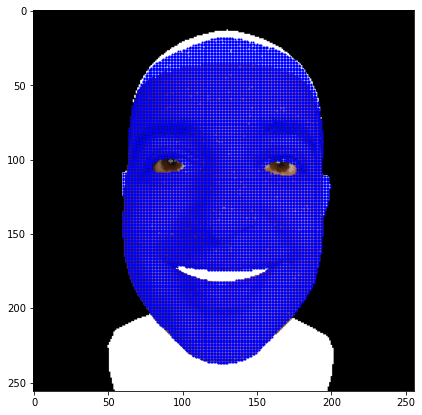

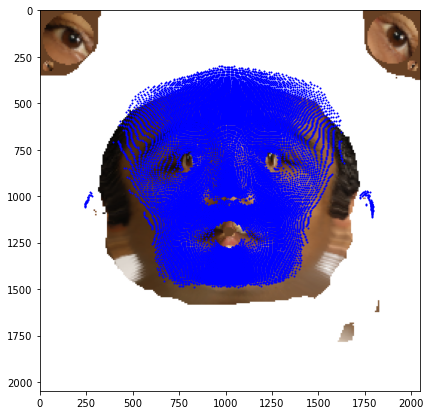

In [3]:
from skimage.transform import PiecewiseAffineTransform, warp
import matplotlib.pyplot as plt

face = render(masked_texture, background, pixel_uvs, background_mask)

def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    return ax

face_np = face[0].permute(1, 2, 0).cpu().numpy()
ax = imshow(face_np)
ax.plot(keypoints[:, 0], keypoints[:, 1], '.b', markersize=2)
plt.show()


texture_np = masked_texture[0].permute(1, 2, 0).cpu().numpy()
ax = imshow(texture_np)
ax.plot(keypoints_uv[:, 0], keypoints_uv[:, 1], '.b', markersize=2)
plt.show()

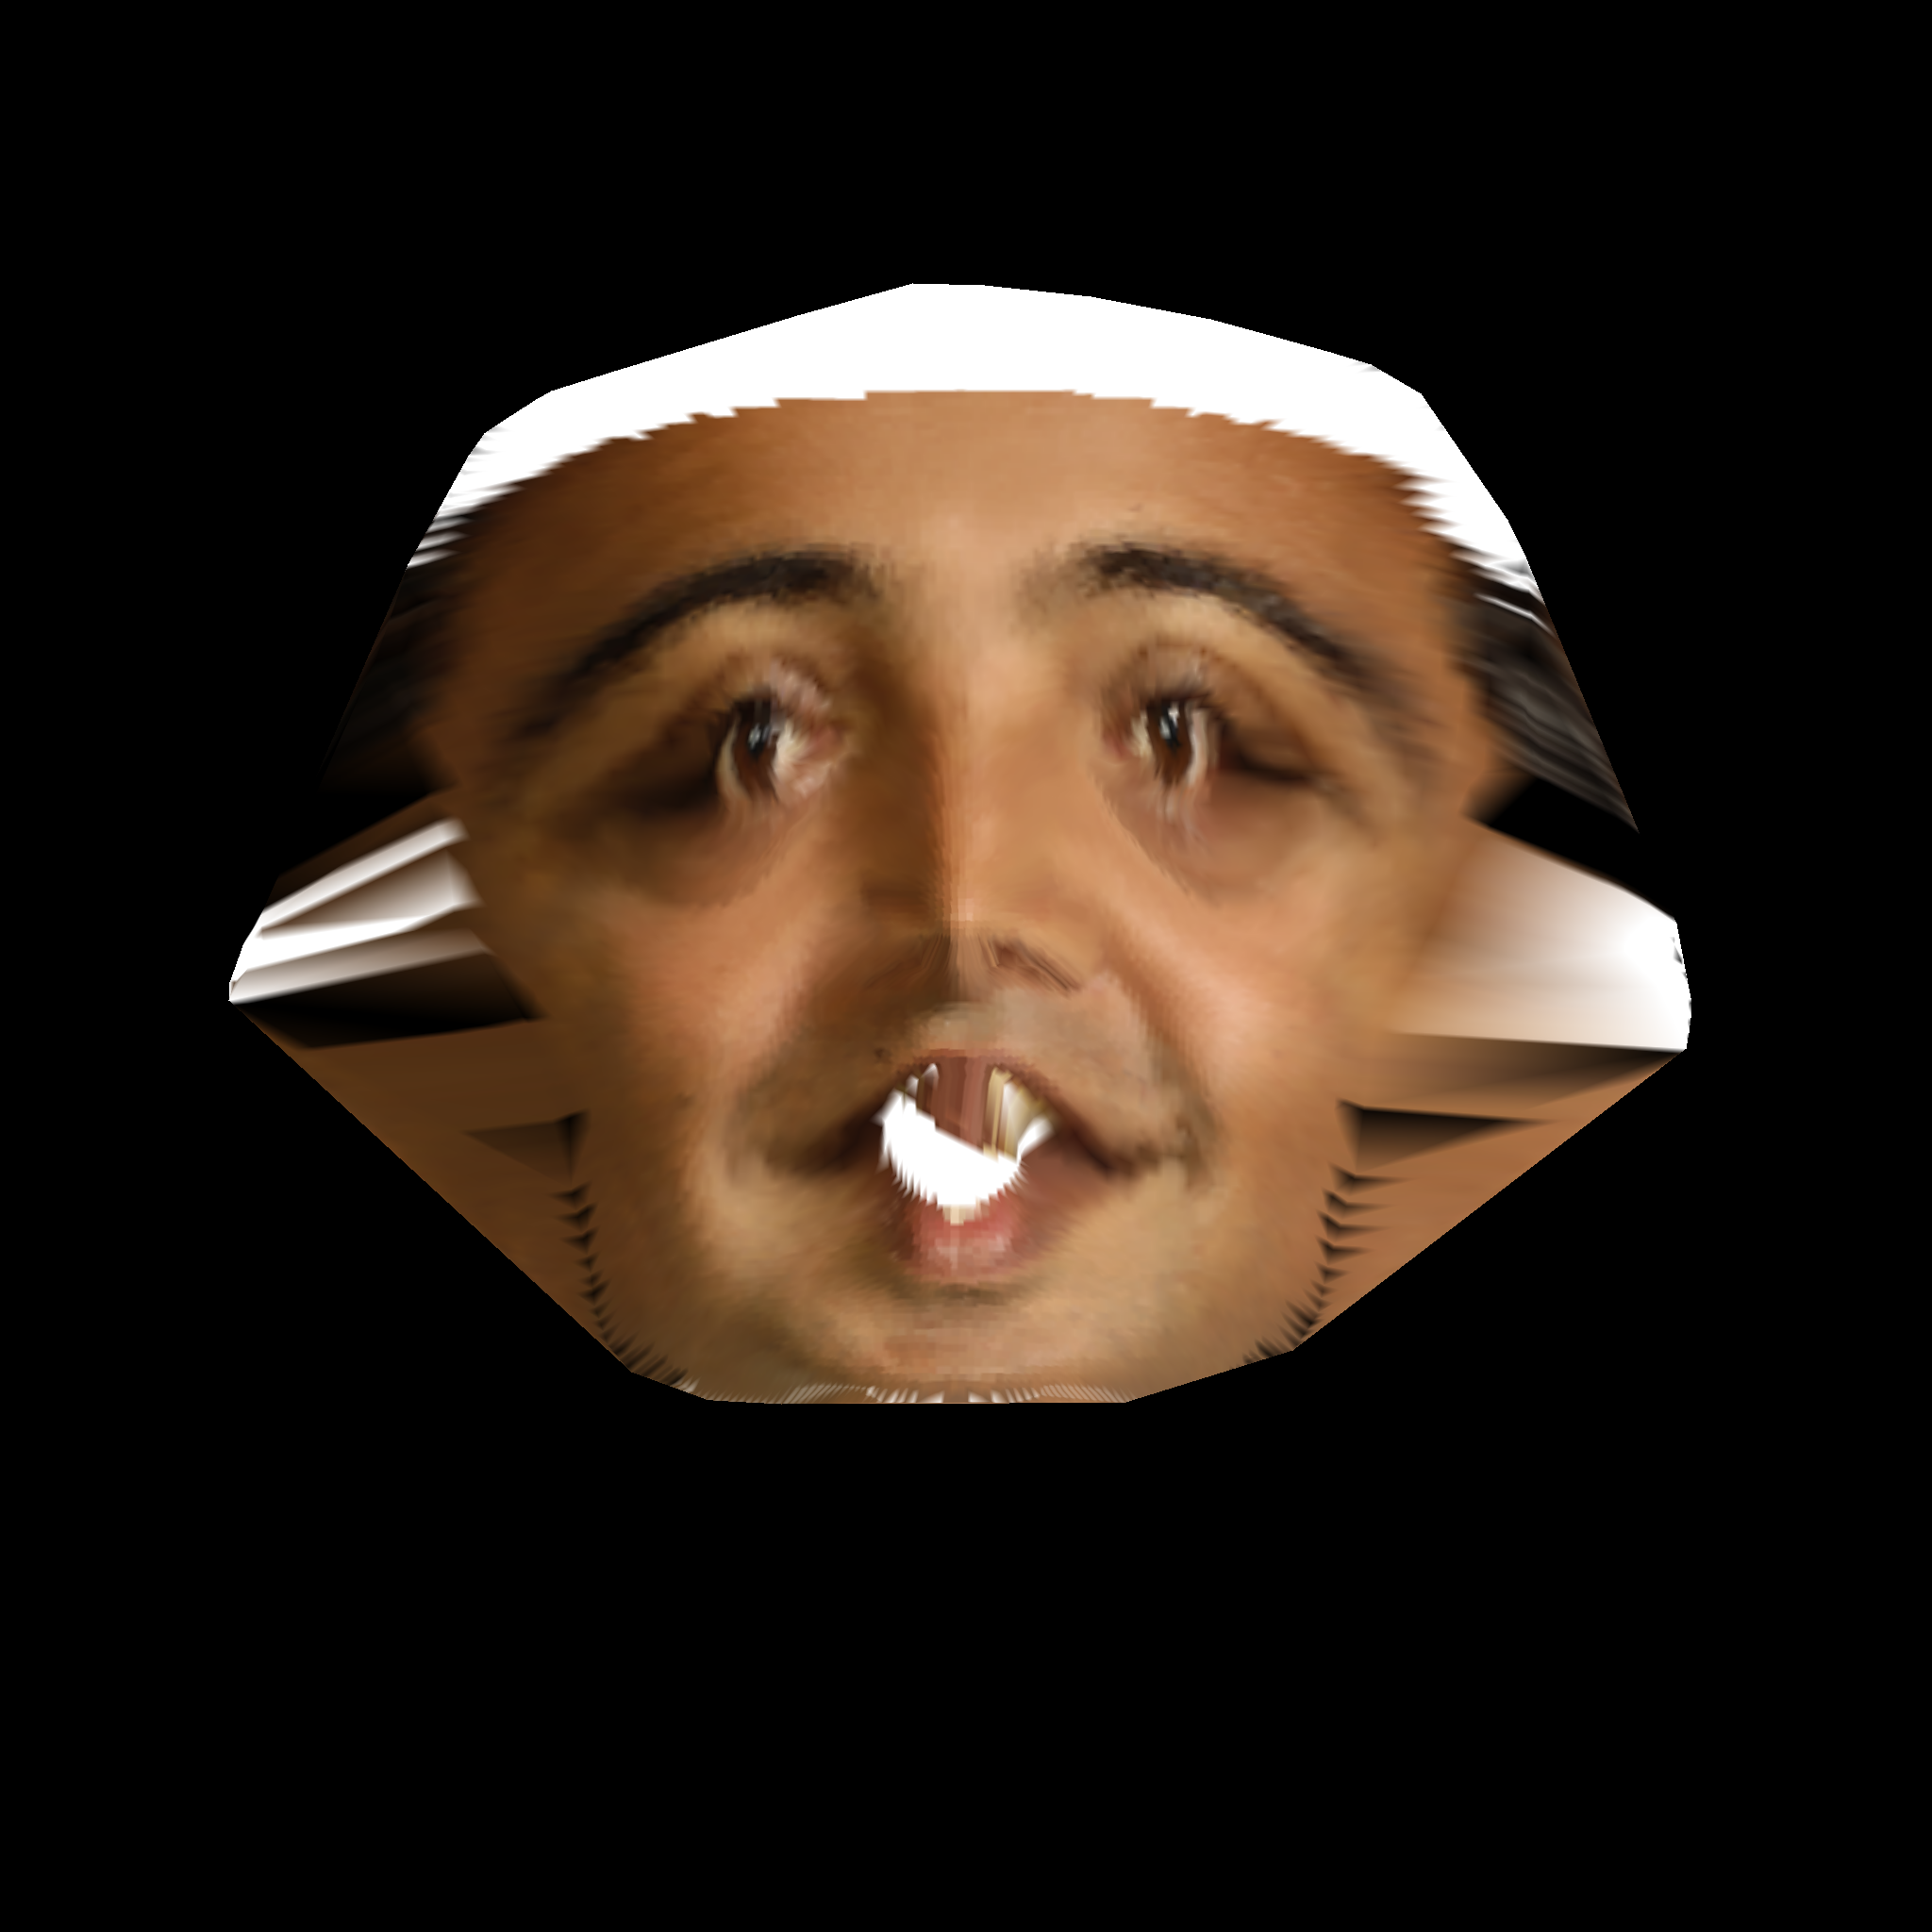

In [4]:
from PIL import Image

tform = PiecewiseAffineTransform()
tform.estimate(keypoints_uv, keypoints)
texture = warp(face_np, tform, output_shape=(cfg["texture_size"], cfg["texture_size"]))
texture = (255 * texture).astype(np.uint8)
Image.fromarray(texture)


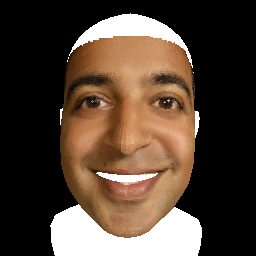

In [10]:
from PIL import Image
import math

new_face = np.zeros(shape=(cfg["image_size"], cfg["image_size"], cfg["num_channels"]))

masked_texture_np = masked_texture[0].permute(1, 2, 0).cpu().numpy()

for y in range(cfg["image_size"]):
    for x in range(cfg["image_size"]):
        u = math.floor( (pixel_uvs[0, y, x, 0] + 1) * cfg["texture_size"] / 2)
        v = cfg["texture_size"] - 1 - math.floor((cfg["texture_size"]) * (pixel_uvs[0, y, x, 1] + 1) / 2)
        in_background = (u == 0 and v == cfg["texture_size"] - 1)
        if in_background:
            current_pixel = np.array([0.0, 0.0, 0.0])
        else:
            if v in v_us_mapping.keys() and u in v_us_mapping[v]:
                current_pixel = np.clip(texture[v, u, :] / 255.0, 0.0, 1.0)
            else:
                current_pixel = np.clip(masked_texture_np[v, u, :], 0.0, 1.0)
        new_face[y, x, :] = current_pixel

new_face = (np.array(new_face) * 255.0).astype(np.uint8)

display(Image.fromarray(new_face))


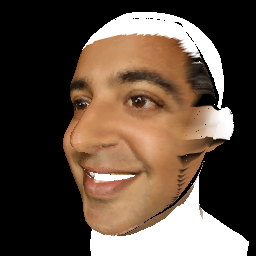

In [11]:
pixel_uvs_30, background_mask_30 = renderer.render(texture=masked_texture, background=background, elev=0.0, azimuth=30.0, result_keys=["pixel_uvs", "background_mask"])

from PIL import Image
import math

new_face = np.zeros(shape=(cfg["image_size"], cfg["image_size"], cfg["num_channels"]))

masked_texture_np = masked_texture[0].permute(1, 2, 0).cpu().numpy()

for y in range(cfg["image_size"]):
    for x in range(cfg["image_size"]):
        u = math.floor( (pixel_uvs_30[0, y, x, 0] + 1) * cfg["texture_size"] / 2)
        v = cfg["texture_size"] - 1 - math.floor((cfg["texture_size"]) * (pixel_uvs_30[0, y, x, 1] + 1) / 2)
        in_background = (u == 0 and v == cfg["texture_size"] - 1)
        if in_background:
            current_pixel = np.array([0.0, 0.0, 0.0])
        else:
            if v in v_us_mapping.keys() and u in v_us_mapping[v]:
                current_pixel = np.clip(texture[v, u, :] / 255.0, 0.0, 1.0)
            else:
                current_pixel = np.clip(masked_texture_np[v, u, :], 0.0, 1.0)
        new_face[y, x, :] = current_pixel

new_face = (np.array(new_face) * 255.0).astype(np.uint8)

display(Image.fromarray(new_face))
